Лысенко Никита 4.8 2020

# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

Основным методом обучения был выбран случайный лес.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

In [3]:
pd.set_option('display.max_columns', None)

## Начнём знакомиться с данными

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
y = train['SalePrice']

In [5]:
train.shape

(1460, 81)

In [6]:
test.shape

(1459, 80)

In [7]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Имеется 81 признак, из которых 38 числовых и 43 категориальных:

In [9]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [10]:
len(numeric_columns)

38

Также среди числовых признаков есть 3 категориальных, которые необходимо отделить. 

In [11]:
object_int_columns = ['MSSubClass', 'OverallQual', 'OverallCond']

In [12]:
numeric_columns = numeric_columns.drop(object_int_columns)
numeric_columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [13]:
object_columns = train.select_dtypes(include=['object']).columns
object_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [14]:
len(object_columns)

43

## Подготовка данных

Для успешного обучения нашей модели необходимо оба датасета привести в подобающий вид. 

Обработка данных разделяется на несколько этапов:

    1) Обработка пропущенных значений
    2) Удаление выбросов
    3) Нормализация данных
    4) Feature Engineering
    5) Превращение категориальных признаков в числовые 
    6) Удаление признаков с высоким коэффициентом корреляции
    7) Трансформация искажённых числовых признаков
    
Так как в нашем датасете довольно мало данных (1460 объектов), важно их сохранить по максимуму.

### 1. Обработка пропущенных значений

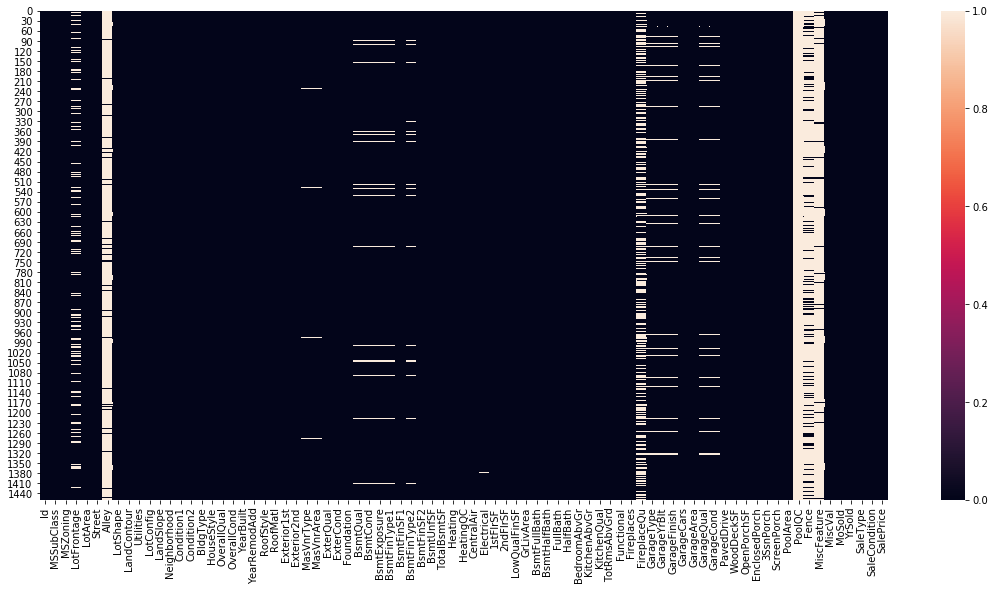

In [15]:
plt.figure(figsize=(19,9))
sns.heatmap(train.isnull())

График heatmap по пустым значениям позволяет увидеть, что происходит с нашими данными. Чёрные области - наличие какого-либо значения, а белые - отсутствие. На глаз видно, что имеется 4 почти белых столбца, означающие почти полное отсутсвие значений. 

In [16]:
def calculate_null_values(df):
    """ Функция для подсчёта пропущенных значений. """
    res = dict()
    for col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            null_percent = round(null_count / df.shape[0] * 100, 4)
            res[col] = (null_count, null_percent)
            print('{}:{} \t{}, \t{}%'.format(col, '\t' if len(col) < 7 else '', null_count, null_percent))
    return res

#### Заполенение пропусков в обучающей выборке train.csv

(Название колонки: количество пропусков, % от общего числа строк)

In [17]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
Alley:	 	1369, 	93.7671%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
FireplaceQu: 	690, 	47.2603%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%
PoolQC:	 	1453, 	99.5205%
Fence:	 	1179, 	80.7534%
MiscFeature: 	1406, 	96.3014%


In [18]:
len(null_values_train)

19

В обучающей выборке имеем 19 признаков c пропущенными значениями 

Глядя на heatmap и процентное соотношение пропусков в датасете, можно сделать следующие выводы:

    1) Есть 4 признака ('Alley', 'PoolQC', 'Fence', 'MiscFeature'), количество пропусков в которых слишком велико, следовательно от них можно избавиться;
    2) Один признак 'FireplaceQu' имеет около 50% пропусков. Соответственно, относительно этого признака нужно будет принять исключительное решение;
    3) Подавляющее большинство признаков имеют небольшой процент пропусков, поэтому есть смысл "побороться" за такие данные.

In [19]:
# 1. избавляемся от "плохих" признаков в обеих выборках
to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [20]:
train.shape

(1460, 77)

In [21]:
# 2. более подробно посмотрим на признак 'FireplaceQu'
train['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

Признак 'FireplaceQu' или Fireplace quality описывает качество домашнего камина, следовательно, пропущенные признаки означают отсутствие камина как такогого. Лучшим способом "борьбы" в данной ситуации будет ввести новую категорию "Na".

In [22]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('Na')

In [23]:
# 3. Обрабатываем остальные пропуски

In [24]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%


In [25]:
train[null_values_train.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
LotFrontage     1201 non-null float64
MasVnrType      1452 non-null object
MasVnrArea      1452 non-null float64
BsmtQual        1423 non-null object
BsmtCond        1423 non-null object
BsmtExposure    1422 non-null object
BsmtFinType1    1423 non-null object
BsmtFinType2    1422 non-null object
Electrical      1459 non-null object
GarageType      1379 non-null object
GarageYrBlt     1379 non-null float64
GarageFinish    1379 non-null object
GarageQual      1379 non-null object
GarageCond      1379 non-null object
dtypes: float64(3), object(11)
memory usage: 159.8+ KB


Имеем 3 числовых и 11 категориальных признаков.

Для числовых признаков пропущенные значения заполним средними значениями:

In [26]:
train['Fireplaces'].value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [27]:
numeric_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_train:
    train[col] = train[col].fillna(0)
    
del numeric_missing_columns_train

С каждым категориальным признаком необходимо провести анализ.

In [28]:
categorical_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_train

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

Пропущенные категориальные можно заполнять двумя способами:
    
    1) взять mode и пропуски заполнить самым часто встречающимся значением
    2) ввести новую категорию NA
  
В зависимости от того, за что отвечает признак, мы и будем принимать решение по дальнейшей обработке.

В ходе детального изучения признаков было выяснено, что отсутствующее значение в датасете означает отсутствие признака как такогого в предполагаемом доме. Следовательно, для каждого (за исключением двух) признака необходимо ввести новую категорию. 

В признаке "Electrical" не предусмотрена категория для пустого значения, следовательно, в данной ситуации все пропуски будем заполнять наиболее встречающимся значением, то есть модой.
В признаке "MasVnrType" предусмотрена категория "none" для отсутствующего значения.

In [29]:
train['Electrical'].unique()

array(['SBrkr', 'FuseF', 'FuseA', 'FuseP', 'Mix', nan], dtype=object)

In [30]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['MasVnrType'] = train['MasVnrType'].fillna('None')
for col in categorical_missing_columns_train:
    train[col] = train[col].fillna('Na')

In [31]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [32]:
categorical_missing_columns_train = categorical_missing_columns_train.drop('Electrical')
categorical_missing_columns_train = categorical_missing_columns_train.drop('MasVnrType')
for col in categorical_missing_columns_train:
    train[col] = train[col].fillna('Na')
    
del categorical_missing_columns_train

In [33]:
miss_cols_train_add_to_none = ['MasVnrType']
for col in miss_cols_train_add_to_none:
    train[col] = train[col].fillna('None')
    
del miss_cols_train_add_to_none

Проверим, все ли мы обработали пустые значения:

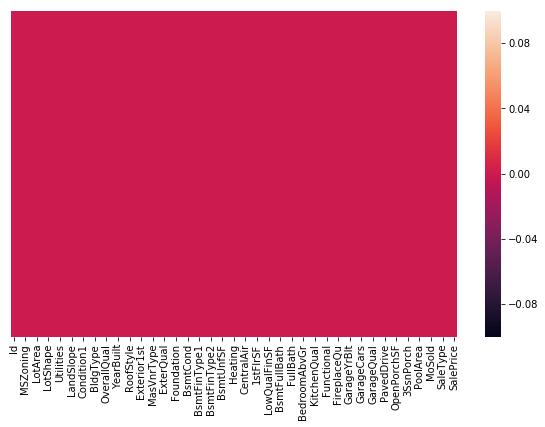

In [34]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(), yticklabels=False)

In [35]:
null_values_train = calculate_null_values(train)
null_values_train

{}

Как видно по графику heatmap и функции calculate_null_values(), в тренировочном датасете больше нет пропущенных значений.

### Заполенение пропусков в тестовой выборке test.csv

In [36]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Alley:	 	1352, 	92.6662%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
PoolQC:	 	1456, 	99.7944%
Fence:	 	1169, 	80.1234%
MiscFeature: 	1408, 	96.5045%
SaleType: 	1, 	0.0685%


In [37]:
len(null_values_test)

33

В тестовой выборке имеем 33 признака c пропущенными значениями

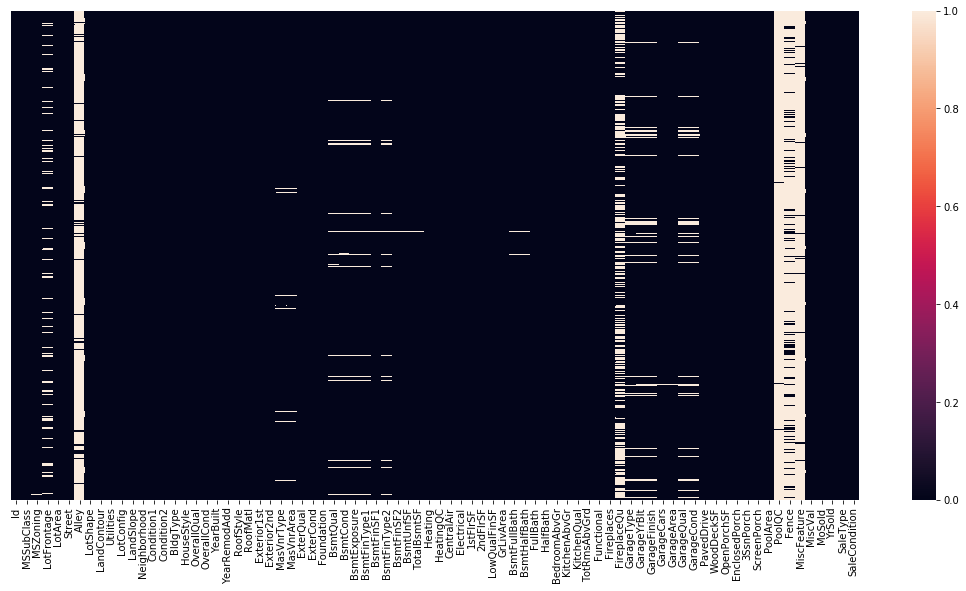

In [38]:
plt.figure(figsize=(19,9))
sns.heatmap(test.isnull(), yticklabels=False)

Имеем 3 числовых и 11 категориальных признаков.

Так же как и в тренировочной, избавляемся от признаков со слишком большим процентом пропусков

In [39]:
# 1. избавляемся от "плохих" признаков в обеих выборках
test.drop(to_drop, axis=1, inplace=True)

In [40]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
SaleType: 	1, 	0.0685%


In [41]:
test[null_values_test.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 29 columns):
MSZoning        1455 non-null object
LotFrontage     1232 non-null float64
Utilities       1457 non-null object
Exterior1st     1458 non-null object
Exterior2nd     1458 non-null object
MasVnrType      1443 non-null object
MasVnrArea      1444 non-null float64
BsmtQual        1415 non-null object
BsmtCond        1414 non-null object
BsmtExposure    1415 non-null object
BsmtFinType1    1417 non-null object
BsmtFinSF1      1458 non-null float64
BsmtFinType2    1417 non-null object
BsmtFinSF2      1458 non-null float64
BsmtUnfSF       1458 non-null float64
TotalBsmtSF     1458 non-null float64
BsmtFullBath    1457 non-null float64
BsmtHalfBath    1457 non-null float64
KitchenQual     1458 non-null object
Functional      1457 non-null object
FireplaceQu     729 non-null object
GarageType      1383 non-null object
GarageYrBlt     1381 non-null float64
GarageFinish    1381 non-null obje

Пропущенные числовые значения также заполним средними значениями:

In [42]:
numeric_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_test:
    test[col] = test[col].fillna(0)
    
del numeric_missing_columns_test

##### Теперь заполним пустоты с категориальными значениями. 

In [43]:
categorical_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_test

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

В ходе детального изучения признаков в тестовой выборке было выяснено, что решение по устранению пустых объектов необходимо принимать, глядя на описание каждого признака.

    FireplaceQu - вводим новую категорию NA
    MSZoning - mode, заполняем пустоты наиболее встречающимся значением
    Utilities - mode, заполняем пустоты наиболее встречающимся значением
    Exterior1st - mode, заполняем пустоты наиболее встречающимся значением
    Exterior2nd - mode, заполняем пустоты наиболее встречающимся значением
    MasVnrType - есть категория none, в которубю необходимо добавить все пропущенные значения
    BsmtQual - вводим новую категорию NA
    BsmtCond - вводим новую категорию NA
    BsmtExposure - вводим новую категорию NA
    BsmtFinType1 - вводим новую категорию NA
    BsmtFinType2 - вводим новую категорию NA
    KitchenQual - mode, заполняем пустоты наиболее встречающимся значением
    Functional - mode, заполняем пустоты наиболее встречающимся значением
    GarageType - вводим новую категорию NA
    GarageFinish - вводим новую категорию NA
    GarageQual - вводим новую категорию NA
    GarageCond - вводим новую категорию NA
    SaleType - mode, заполняем пустоты наиболее встречающимся значением

In [44]:
miss_cols_test_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 
                       'SaleType']

miss_cols_test_new_cat_NA = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                             'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

miss_cols_test_add_to_none = ['MasVnrType']

In [45]:
for col in miss_cols_test_mode:
    test[col] = test[col].fillna(test[col].mode()[0])

del miss_cols_test_mode

In [46]:
for col in miss_cols_test_new_cat_NA:
    test[col] = test[col].fillna('Na')
    
del miss_cols_test_new_cat_NA

In [47]:
for col in miss_cols_test_add_to_none:
    test[col] = test[col].fillna('None')
    
del miss_cols_test_add_to_none

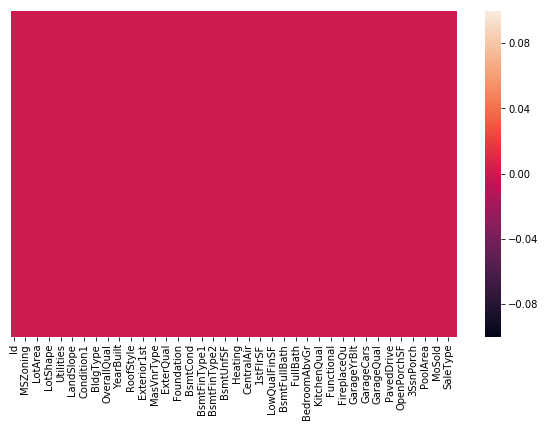

In [48]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(), yticklabels=False)

In [49]:
null_values_test = calculate_null_values(test)
null_values_test

{}

Как видно по графику heatmap и функции calculate_null_values(), в тестовом датасете больше нет пропущенных значений.

Первый этап обработки данных завершён.

In [50]:
train.to_csv("data/final_without_miss.csv", index=False)
test.to_csv("data/final_without_miss.csv", index=False)

## 2. Удаление выбросов

Для того чтобы отследить выбросы, необходимо посмотреть на каждый числовой признак относительно целевого признака. 

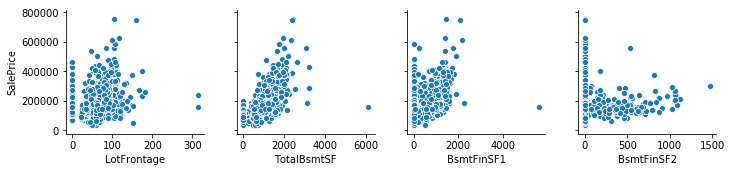

In [51]:
cols5 = ['LotFrontage', 'TotalBsmtSF', 'BsmtFinSF1', 'BsmtFinSF2']
sns.pairplot(train, y_vars=['SalePrice'], x_vars=cols5)

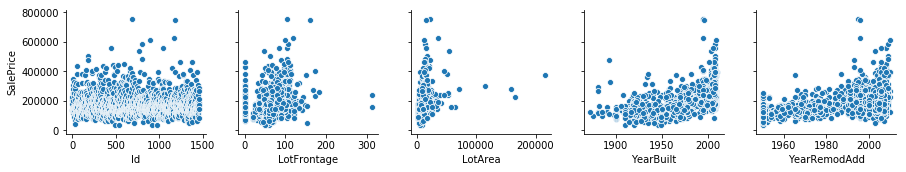

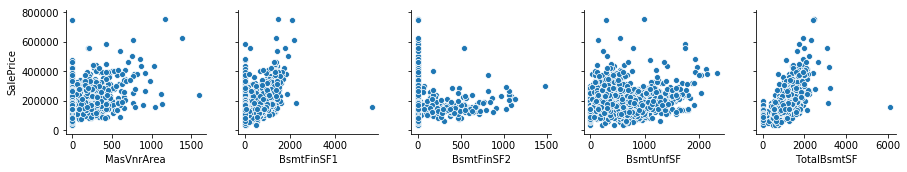

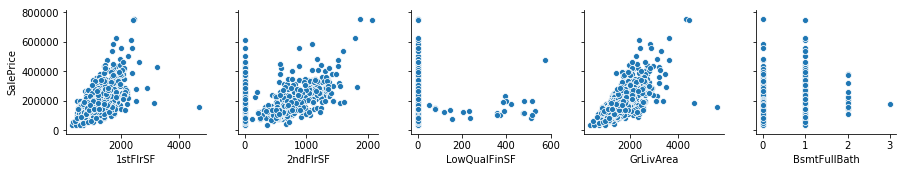

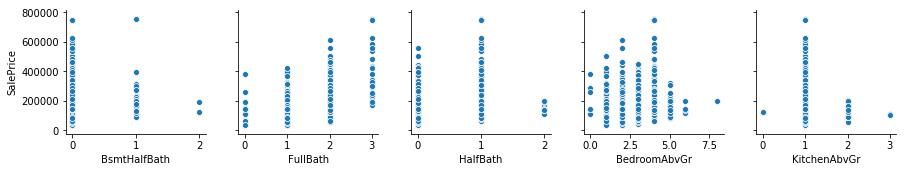

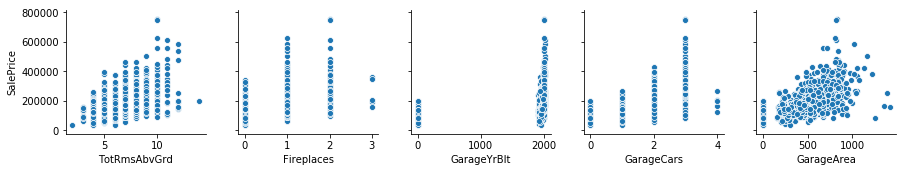

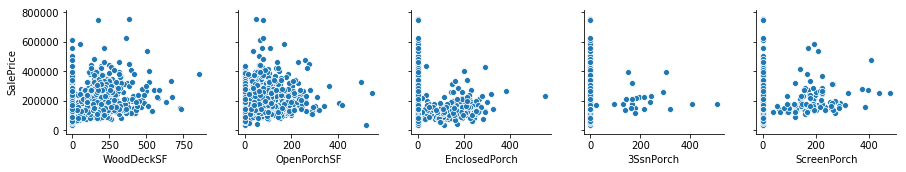

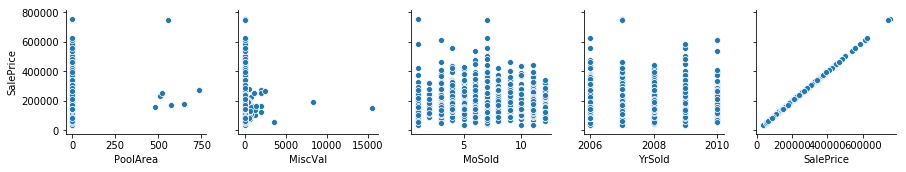

In [52]:
cols5 = []
for i in range(0, len(numeric_columns), 5):
    cols5.append(numeric_columns[i : i + 5])
    
# Далее выыведем графики зависимостей численных признаков от целевой переменной
for x in cols5:
    sns.pairplot(train, y_vars=['SalePrice'], x_vars=x)

Глядя на данные графики, можно сделать выводы о выбросах для каждого признака

Для подавляющего большинства признаков выбросов не наблюдается.
Однако есть признаки, у которых они всё таки наблюдаются:

    "LotArea" > 100000
    "LotFrontage" > 300
    "BsmtFinSF1" > 4000 
    "TotalBsmtSF" > 6000
    "1stFlrSF" > 4000
    "GrLivArea" > 5000
   
Запишем выбросы в переменную, чтобы далее от них избавиться.

In [53]:
outliers = {
    "LotArea": 100000, 
    "LotFrontage": 300,
    "BsmtFinSF1": 4000, 
    "TotalBsmtSF": 6000, 
    "1stFlrSF": 4000, 
    "GrLivArea": 5000
}

In [54]:
train.shape

(1460, 77)

In [55]:
for col in outliers: 
    train = train[train[col] < outliers[col]]
    test = test[test[col] < outliers[col]]

In [56]:
train.shape

(1454, 77)

In [57]:
train.to_csv("data/final_without_outliers.csv", index=False)
test.to_csv("data/final_without_outliers.csv", index=False)

## 3. Нормализация данных

Алгоритм случайного леса не нуждается в нормализации данных. Следовательно, данный этап предобработки можно пропустить.

## 4. Feature Engineering

In [58]:
train['TotalArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
train['TotalBath'] = train['BsmtFullBath'] + train['FullBath'] + (train['BsmtHalfBath'] + train['HalfBath']) * 0.5
train['TotalPorchSF'] = (train['OpenPorchSF'] + train['3SsnPorch'] + 
                         train['EnclosedPorch'] + train['ScreenPorch'] + 
                         train['WoodDeckSF'])

test['TotalArea'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']
test['TotalBath'] = test['BsmtFullBath'] + test['FullBath'] + (test['BsmtHalfBath'] + test['HalfBath']) * 0.5
test['TotalPorchSF'] = (test['OpenPorchSF'] + test['3SsnPorch'] + 
                        test['EnclosedPorch'] + test['ScreenPorch'] + 
                        test['WoodDeckSF'])

to_drop = ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'BsmtFullBath', 'FullBath', 'BsmtHalfBath', 'HalfBath', 
          'OpenPorchSF', '3SsnPorch', 'EnclosedPorch', 'ScreenPorch', 'WoodDeckSF']

train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = numeric_columns.drop(to_drop)
numeric_columns.append(pd.Index(['TotalArea', 'TotalBath', 'TotalPorchSF']))

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF',
       'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'TotalArea', 'TotalBath',
       'TotalPorchSF'],
      dtype='object')

In [59]:
train.shape

(1454, 68)

## 5. Превращение категориальных признаков в числовые

Посмотрим подробнее на каждый категориальный признак

In [60]:
def plot_barh(df, cols, ncols=4):
    num_col = 0
    for i in range(len(cols) // ncols):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 3), dpi=100)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        for j in range(ncols):
            ax = df[cols[num_col]].value_counts().plot.barh(ax=axes[j], fontsize=10)
            ax.set_xlabel(cols[num_col], fontsize = 12)
            num_col += 1

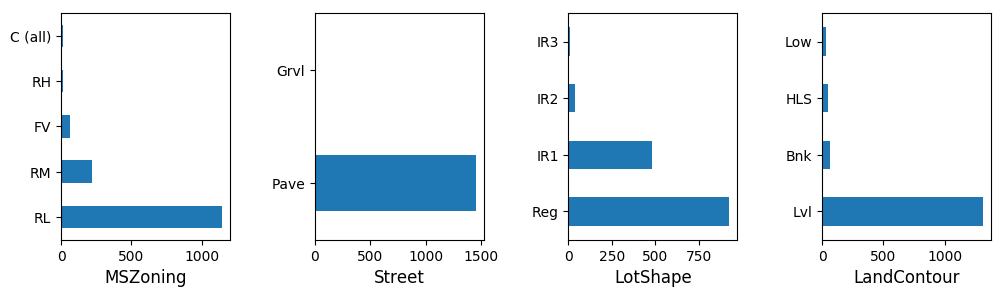

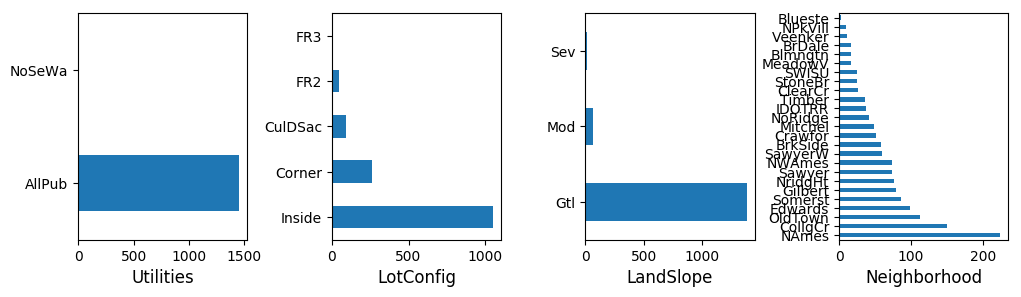

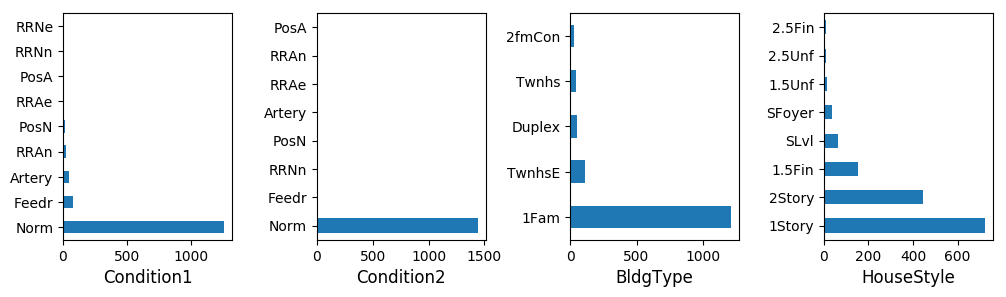

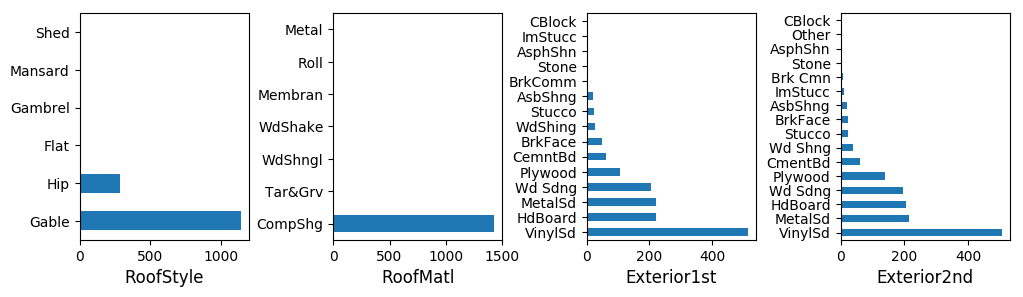

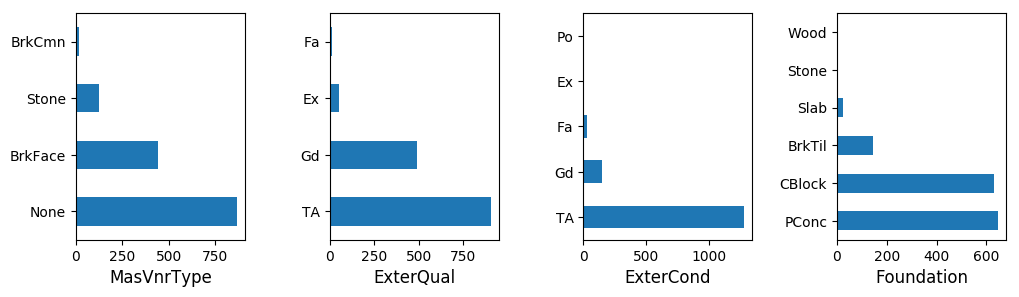

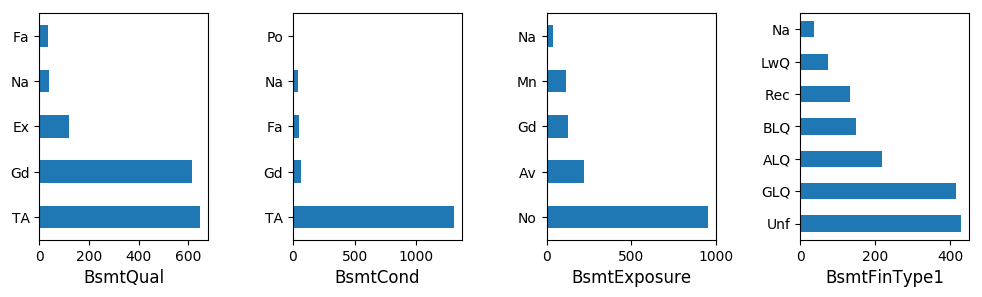

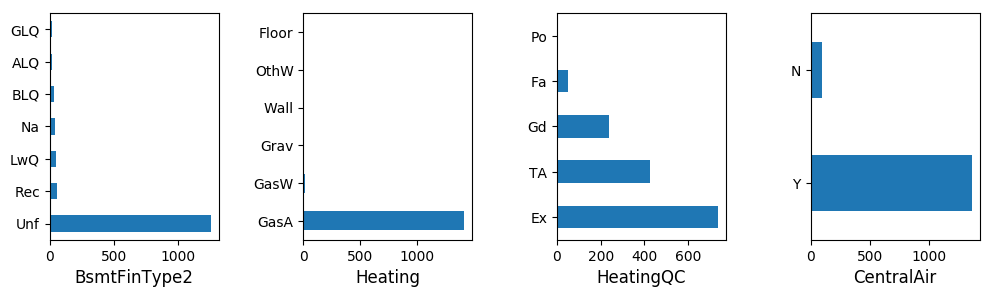

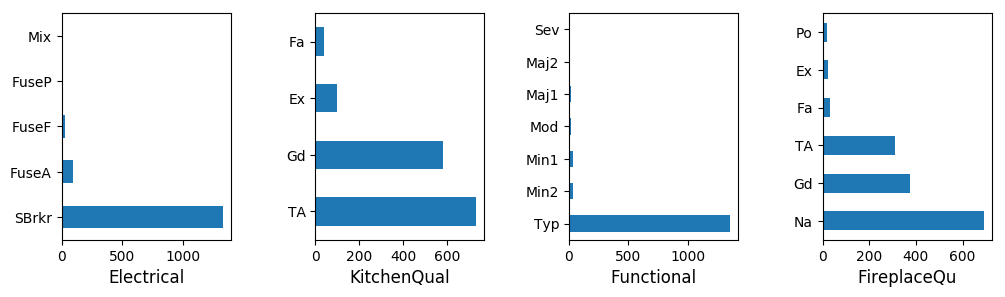

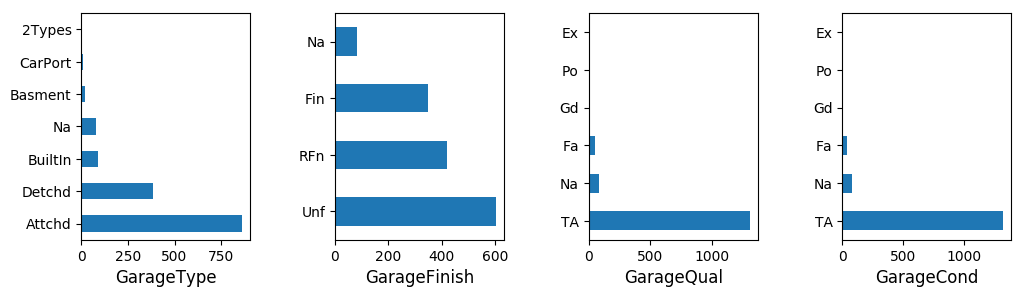

In [61]:
plot_barh(df=train, cols=object_columns)

Имеется несколько признаков, в которых одна категория значительно преобладает над другими.  

Например:

Подобные признаки не смогут положительно повлиять на качество нашей модели.

In [62]:
to_drop = ['Street', 'Utilities', 'Condition2', 'Heating', 'RoofMatl'] 

In [63]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [64]:
train.shape

(1454, 63)

In [65]:
# One-hot-encoding
# train = pd.get_dummies(train, columns=list(object_columns) + object_int_columns)
# test = pd.get_dummies(test, columns=list(object_columns) + object_int_columns)
# train.columns

In [66]:
# X_train.drop(['Electrical_Mix', 'Exterior1st_ImStucc', 'Exterior1st_Stone', 
#                         'Exterior2nd_Other', 'GarageQual_Ex', 'HouseStyle_2.5Fin'], axis=1, inplace=True)
# X_test.drop(['MSSubClass_150'], axis=1, inplace=True)

In [67]:
label_encoder = LabelEncoder()

for col in object_columns:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TotalArea,TotalBath,TotalPorchSF
0,1,60,3,65.0,8450,3,3,4,0,5,2,0,5,7,5,2003,2003,1,12,13,1,196.0,2,4,2,2,4,4,2,706,6,0,150,0,1,4,0,1710,3,1,2,8,6,0,3,1,2003.0,2,2,548,5,5,2,0,0,2,2008,8,4,208500,2566,3.5,61
1,2,20,3,80.0,9600,3,3,2,0,24,1,0,2,6,8,1976,1976,1,8,8,2,0.0,3,4,1,2,4,1,0,978,6,0,284,0,1,4,0,1262,3,1,3,6,6,1,5,1,1976.0,2,2,460,5,5,2,0,0,5,2007,8,4,181500,2524,2.5,298
2,3,60,3,68.0,11250,0,3,4,0,5,2,0,5,7,5,2001,2002,1,12,13,1,162.0,2,4,2,2,4,2,2,486,6,0,434,0,1,4,0,1786,3,1,2,6,6,1,5,1,2001.0,2,2,608,5,5,2,0,0,9,2008,8,4,223500,2706,3.5,42
3,4,70,3,60.0,9550,0,3,0,0,6,2,0,5,7,5,1915,1970,1,13,15,2,0.0,3,4,0,4,1,4,0,216,6,0,540,2,1,4,0,1717,3,1,2,7,6,1,2,5,1998.0,3,3,642,5,5,2,0,0,2,2006,8,0,140000,2473,2.0,307
4,5,60,3,84.0,14260,0,3,2,0,15,2,0,5,8,5,2000,2000,1,12,13,1,350.0,2,4,2,2,4,0,2,655,6,0,490,0,1,4,0,2198,4,1,2,9,6,1,5,1,2000.0,2,3,836,5,5,2,0,0,12,2008,8,4,250000,3343,3.5,276


## 6. Удаление признаков с высоким коэффициентом корреляции

In [68]:
def pairs_of_corr(df):
    corr = df.corr()
    corr_list = list()
    corr_cols = set()
    for i in range(len(df.columns)):
        for j in range(i + 1, len(df.columns)):
            col1 = df.columns[i];
            col2 = df.columns[j];
            if col1 == 'SalePrice' or col2 == 'SalePrice':
                continue
            if corr[col1][col2] > 0.5:
                corr_cols.add(col1)
                corr_cols.add(col2)
                corr_list.append((col1, col2, corr[col1][col2]))
    return list(reversed(sorted(corr_list, key=lambda x: x[-1]))), corr_cols

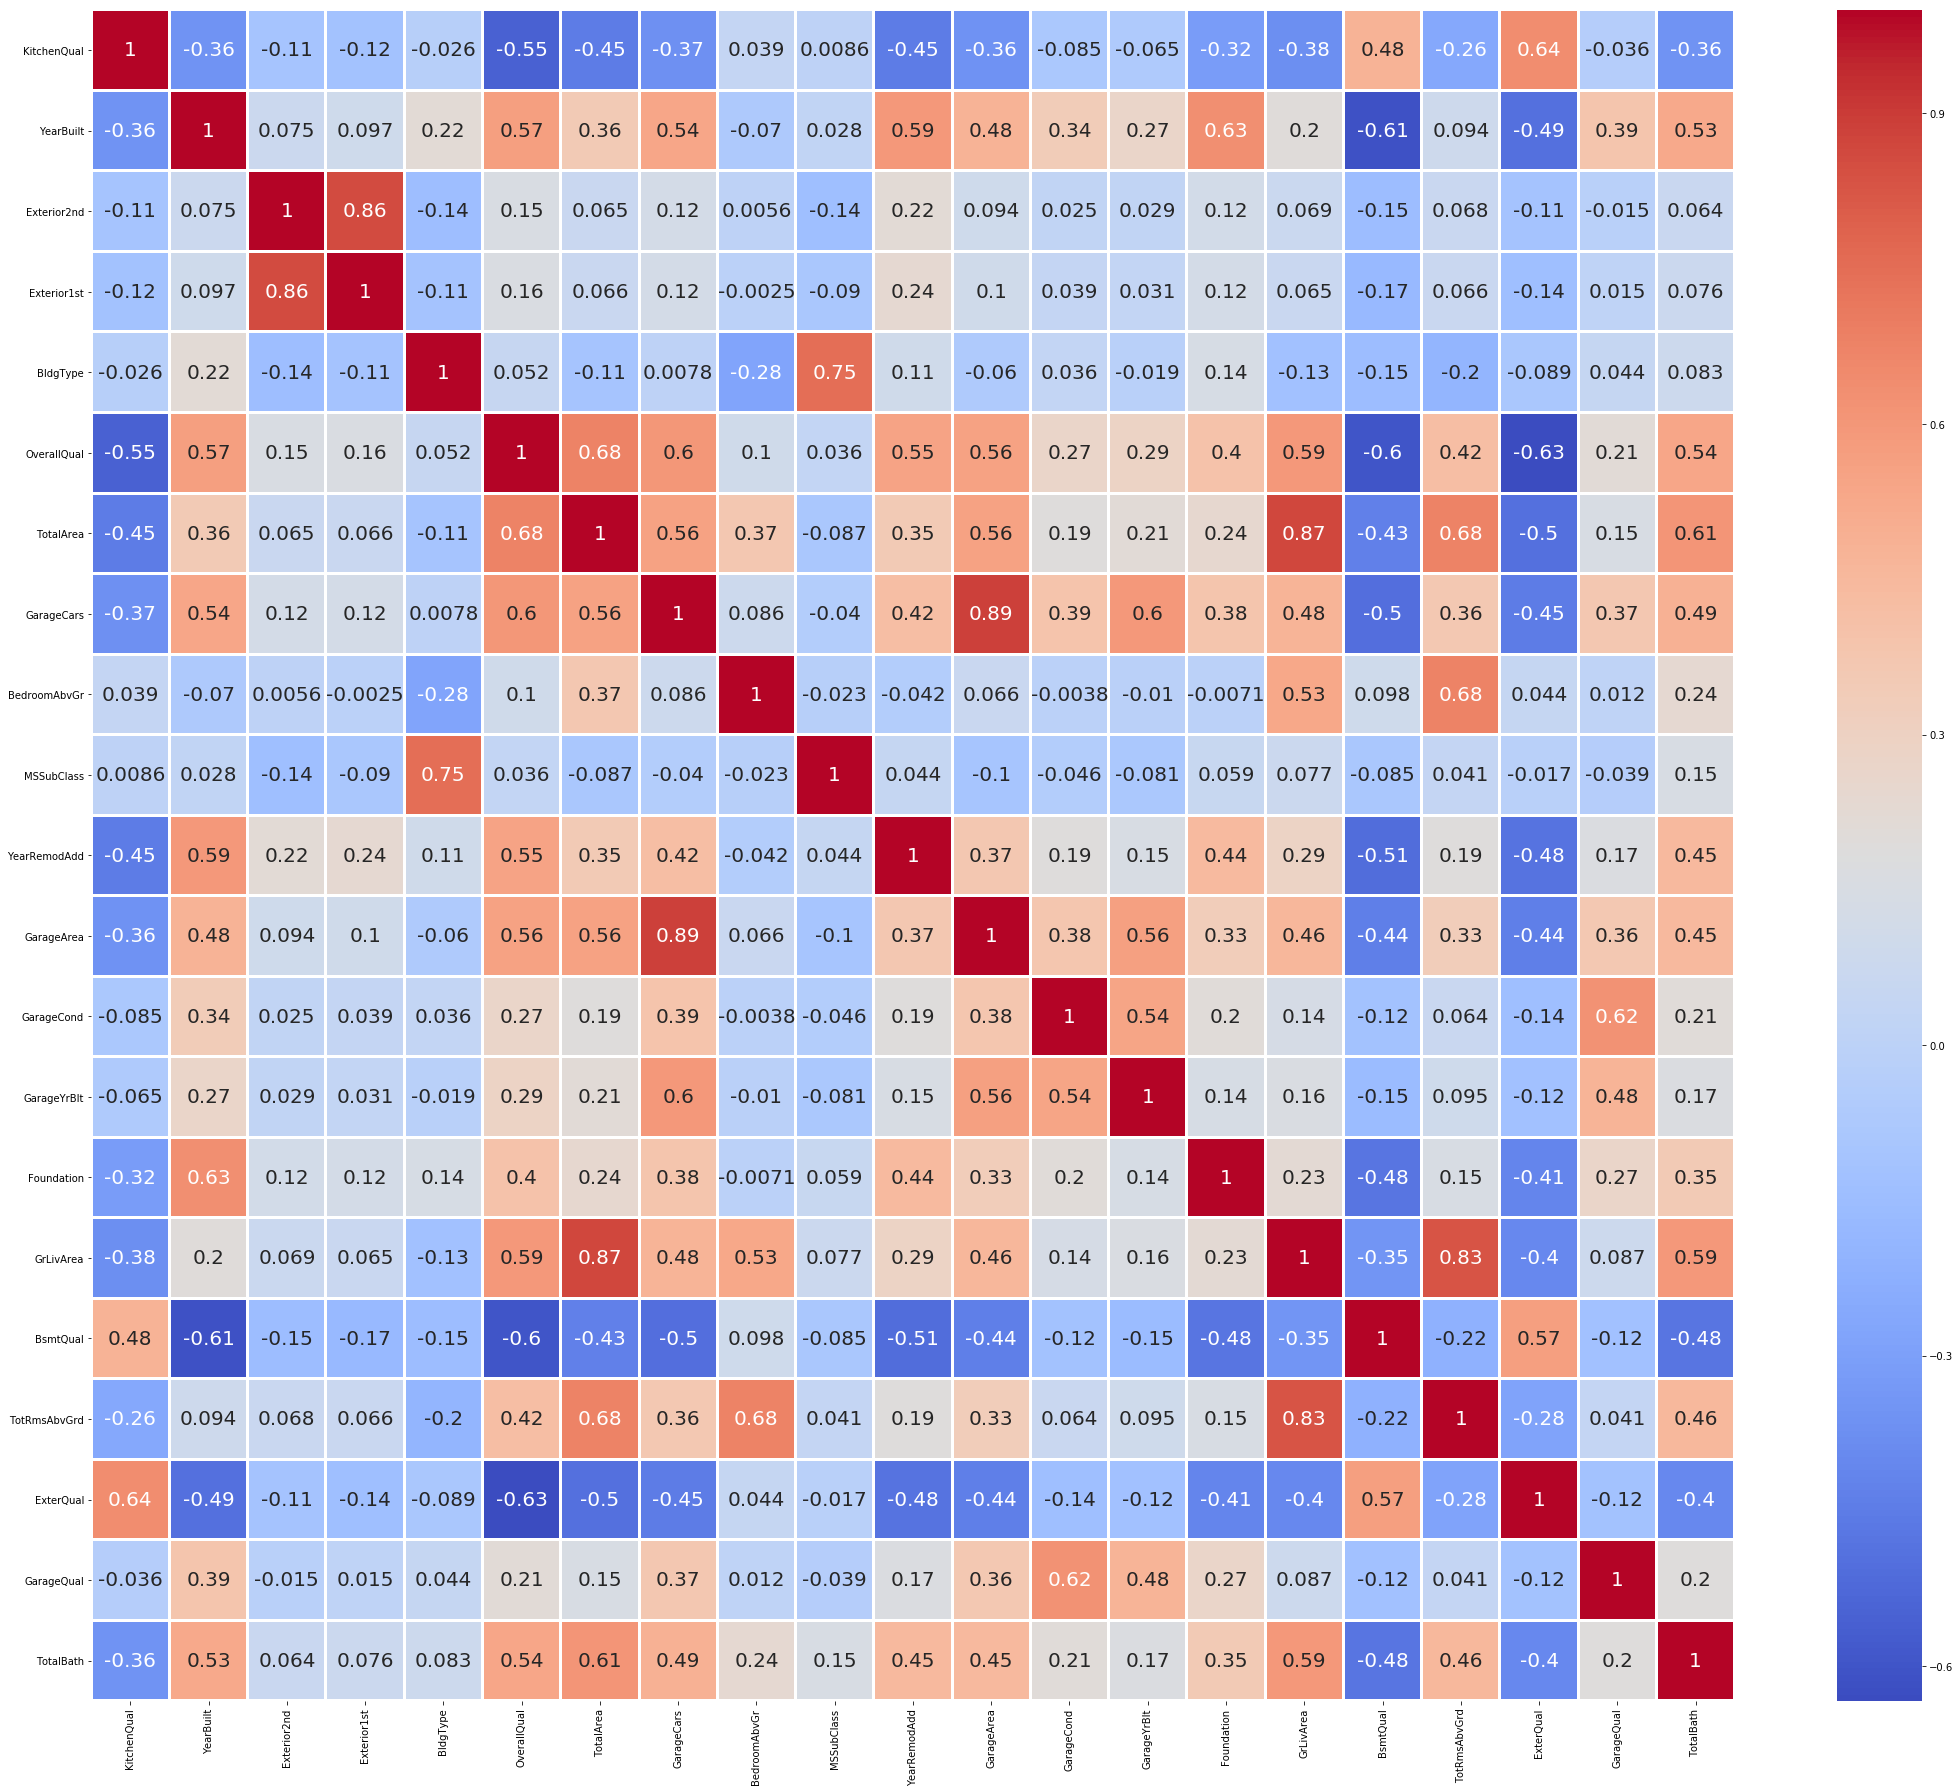

In [69]:
corrmat = train.corr()
corr_cols = pairs_of_corr(train)[1]
cm = np.corrcoef(train[corr_cols].values.T)

plt.figure(figsize=(30,25))
fig = sns.heatmap(cm, cmap = "coolwarm", annot=True, linewidth=2, annot_kws={'fontsize': 20}, 
                 yticklabels =corr_cols, xticklabels = corr_cols).get_figure()
plt.tight_layout()
# sns.set(font_scale=4)
# fig.savefig("figures/corr_matrix.png")

Посмотрим на признаки с максимальными значениями корреляции по отношению друг к другу

In [70]:
pairs_of_corr(train)[0]

[('GarageCars', 'GarageArea', 0.8879255985464204),
 ('GrLivArea', 'TotalArea', 0.8703540145384712),
 ('Exterior1st', 'Exterior2nd', 0.8552659216090391),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8288906634780077),
 ('MSSubClass', 'BldgType', 0.7477869436978508),
 ('TotRmsAbvGrd', 'TotalArea', 0.6807730322529032),
 ('OverallQual', 'TotalArea', 0.6794176651143844),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.6784968009707368),
 ('ExterQual', 'KitchenQual', 0.6395274733936954),
 ('YearBuilt', 'Foundation', 0.6345730836156714),
 ('GarageQual', 'GarageCond', 0.6182362749786222),
 ('TotalArea', 'TotalBath', 0.6088710287860383),
 ('OverallQual', 'GarageCars', 0.6019936688572667),
 ('GarageYrBlt', 'GarageCars', 0.5978986576347146),
 ('YearBuilt', 'YearRemodAdd', 0.5938417300365315),
 ('GrLivArea', 'TotalBath', 0.5934045496728955),
 ('OverallQual', 'GrLivArea', 0.5924667572149163),
 ('OverallQual', 'YearBuilt', 0.5724116665521873),
 ('ExterQual', 'BsmtQual', 0.5714224702419548),
 ('GarageYrBlt', 'GarageArea', 0

In [71]:
to_drop = ['GarageCars', 'GrLivArea', 'Exterior2nd', 'MSSubClass' , 
           'TotRmsAbvGrd', 'OverallQual', 'KitchenQual', 'Foundation', 
           'GarageQual', 'TotalBath', 'YearBuilt', 'GarageArea', 
           'GarageYrBlt', 'BsmtQual']

In [72]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)

In [73]:
pairs_of_corr(train)[0]

[]

In [74]:
train.shape

(1454, 49)

In [75]:
train.to_csv("data/b_skewed_train.csv", index=False)
test.to_csv("data/b_skewed_test.csv", index=False)

## 7. Трансформация искажённых числовых признаков

In [88]:
# train = pd.read_csv("data/final_without_outliers.csv")
# test = pd.read_csv("data/final_without_outliers.csv")

train = pd.read_csv("data/b_skewed_train.csv")
test = pd.read_csv("data/b_skewed_test.csv")

Искажённые или асимметричные признаки - ещё одна проблема, которая может повлиять на качество модели. Алгоритмы машинного обучения подразумевают, что на вход подаются данные,имеющий гауссово распределие. 

Посмотрим на асимметрию в данных и преобразуем те признаки, у которых коэффициент асимметрии велик.

In [89]:
skewed_before = train.apply(lambda x: stats.skew(x.astype('float')))
skewed_before = skewed_before[abs(skewed_before) > 0.5]
skewed_before

MSZoning         -1.730630
LotArea           3.939136
LotShape         -0.614731
LandContour      -3.216038
LotConfig        -1.143847
LandSlope         4.896300
Condition1        3.017887
BldgType          2.237912
OverallCond       0.694177
YearRemodAdd     -0.502464
RoofStyle         1.481123
Exterior1st      -0.724529
MasVnrArea        2.694851
ExterQual        -1.824684
ExterCond        -2.555196
BsmtCond         -2.930990
BsmtExposure     -0.997242
BsmtFinSF1        0.799002
BsmtFinType2     -3.184852
BsmtFinSF2        4.279205
BsmtUnfSF         0.916339
CentralAir       -3.517836
Electrical       -3.051798
LowQualFinSF      8.982890
KitchenAbvGr      4.473226
Functional       -4.070925
Fireplaces        0.632566
GarageType        0.635289
GarageFinish     -0.621025
GarageCond       -3.571072
PavedDrive       -3.296973
PoolArea         15.910404
MiscVal          24.469277
SaleType         -3.860688
SaleCondition    -2.733383
SalePrice         1.896903
TotalArea         0.967386
T

Имеется 38 признаков с высоким коэффициентом асимметрии.

In [90]:
len(skewed_before)

38

Посмотрим на графики распределения наших численных признаков

In [99]:
def plot_skewed(df, skewed):
    plt.figure(figsize=(30,100))
    for i in range(len(skewed)):
        plt.subplot(13, 3, i + 1)
        plt.subplots_adjust(hspace = 0.6, wspace = 0.5)
        ax = sns.distplot(df[skewed.index[i]])
        ax.legend(["Skewness: {:.2f}".format(df[skewed.index[i]].skew())], fontsize='xx-large')
        ax.set_xlabel(skewed.index[i], fontsize = 20)
    # sns.set(font_scale=0.5)
    plt.savefig('figures/test.png')

In [112]:
def plot_small_skewed(df, skewed):
    plt.figure(figsize=(12, 3), dpi=100)
    for i, col in enumerate(skewed):
        plt.subplot(1, 4, i + 1)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        ax = sns.distplot(df[col])
        ax.legend(["Skewness: {:.2f}".format(df[col].skew())], fontsize=12)
        ax.set_xlabel(col, fontsize = 12)
    # sns.set(font_scale=0.5)
    plt.savefig('figures/test.png')
    

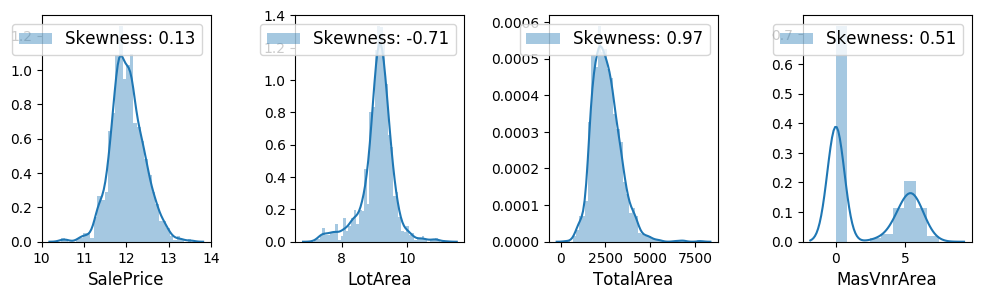

In [113]:
skewed_ = ['SalePrice', 'LotArea', 'TotalArea', 'MasVnrArea']
plot_small_skewed(df=train, skewed=skewed_)

По графикам видно, что большинство наших признаков имеют позитивную ассиметрию (или правую). Побороться с данным видос ассиметрии можно с помощью логарифмирования.

Для примера посмотрим на распределение данных целевого признака "SalePrice" до и после логарифмирования. 

count      1454.000000
mean     180577.713893
std       79310.982054
min       34900.000000
25%      129900.000000
50%      162950.000000
75%      213497.500000
max      755000.000000
Name: SalePrice, dtype: float64

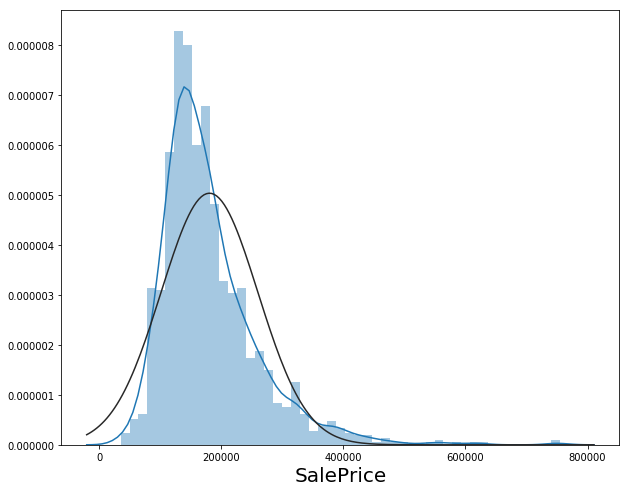

In [83]:
ax = sns.distplot(train['SalePrice'], fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)
train['SalePrice'].describe()

count    1454.000000
mean       12.022289
std         0.398972
min        10.460242
25%        11.774520
50%        12.001199
75%        12.271380
max        13.534473
Name: SalePrice, dtype: float64

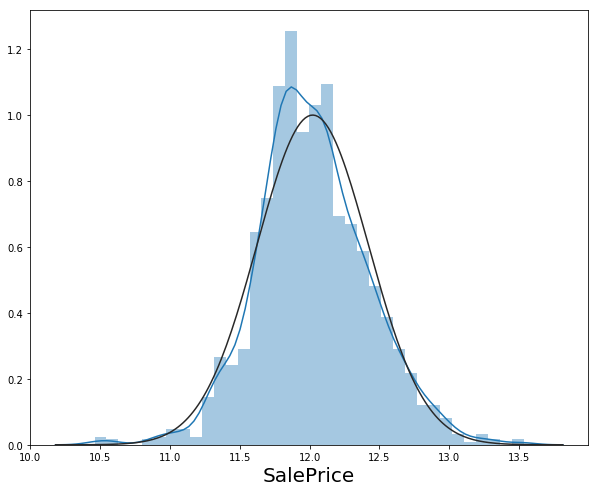

In [84]:
ax = sns.distplot(np.log(train['SalePrice']), fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)
np.log(train['SalePrice']).describe()

Видим, что после логарифмирования целевой признак действительно приобрел вид гауссового распределения.

Далее применим логарифмирование для всех числовых признаков в обоих датасетах. 

In [106]:
# так как log() превращает 0 в -inf, то используем функцию log(x+1), которая лучше работает с маленькими значениями
for col in skewed_before.index:
    if skewed_before[col] > 1:
        train[col] = np.log(train[col] + 1)
        if col == 'SalePrice':
            continue
        test[col] = np.log(test[col] + 1)
    elif skewed_before[col] < -1:
        train[col] = np.exp(train[col]) - 1
        if col == 'SalePrice':
            continue
        test[col] = np.exp(test[col]) - 1

In [86]:
# train['BsmtUnfSF'] = np.exp(train['BsmtUnfSF']) - 1
# test['BsmtUnfSF'] = np.exp(test['BsmtUnfSF']) - 1

In [87]:
skewed_after = train.apply(lambda x: stats.skew(x.astype('float')))
skewed_after = skewed_after[abs(skewed_after) > 0.5]
len(skewed_after)

37

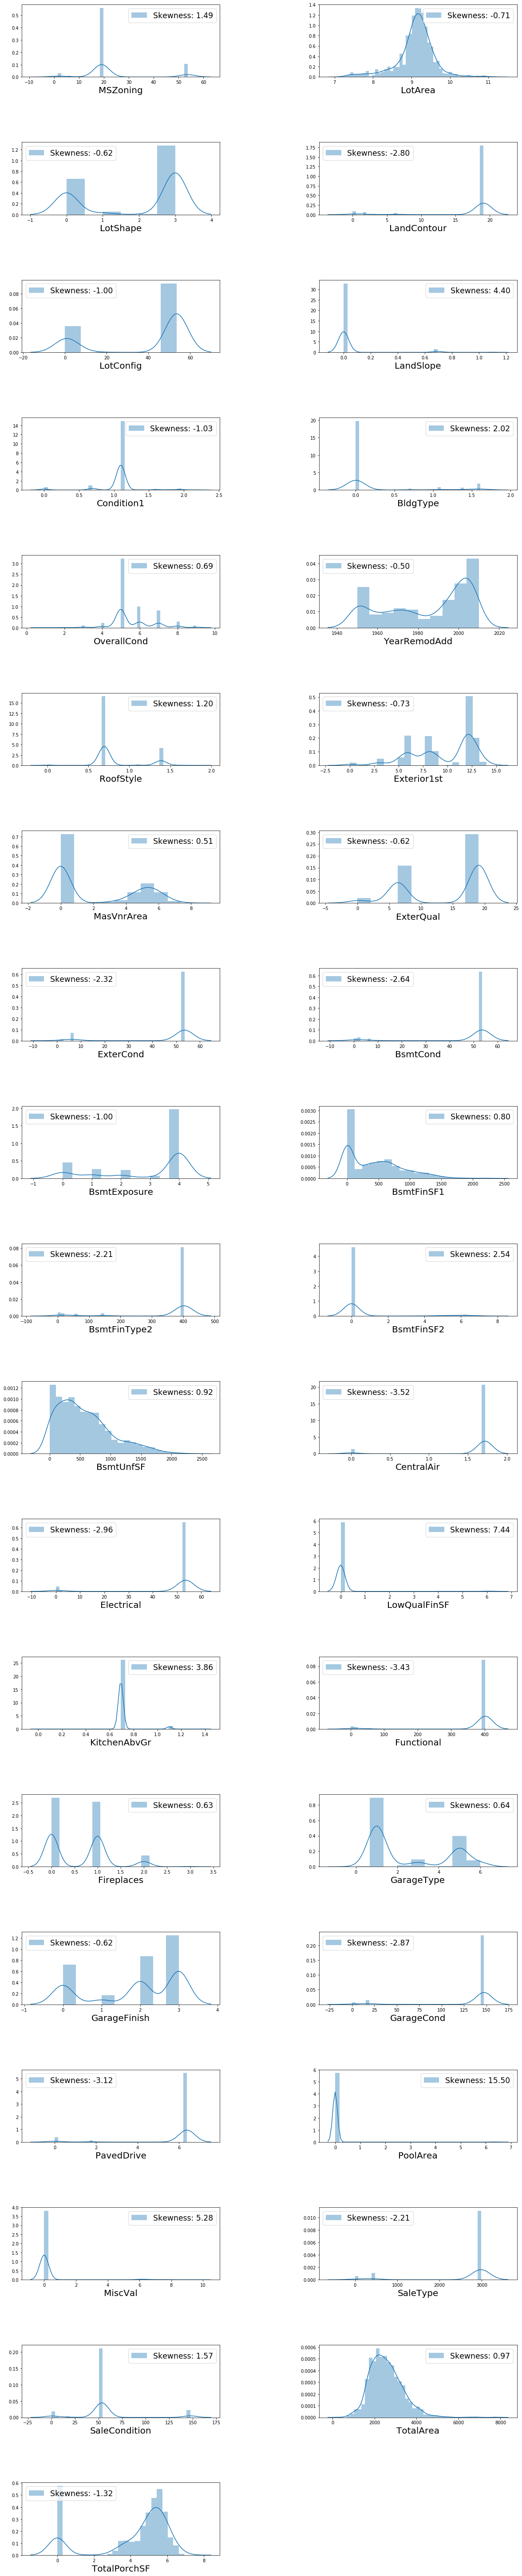

In [88]:
plot_skewed(df=train, skewed=skewed_after)

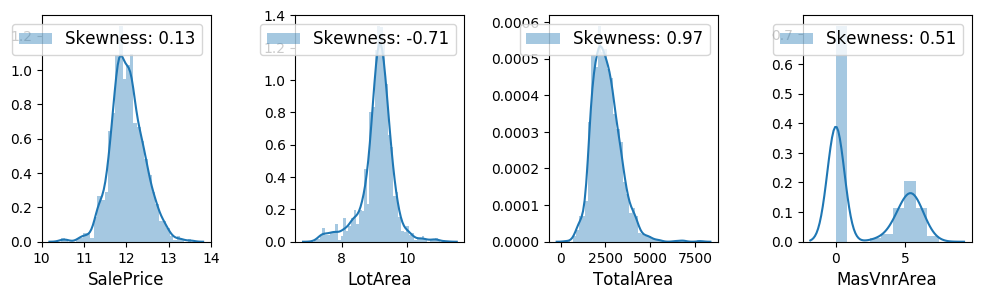

In [107]:
plot_small_skewed(df=train, skewed=skewed_)

Есть признаки у которых ситуация ухудшилась, поэтому необходимо их восстановить

In [89]:
return_skewed = list()
for x in skewed_after.index:
    if abs(skewed_before[x]) != abs(skewed_after[x]):
        print(x, "\tbefore:", skewed_before[x] , "\tafter:", skewed_after[x])
        return_skewed.append(x)

MSZoning 	before: -1.7306303722439222 	after: 1.4861257218083768
LotArea 	before: 3.9391362926886884 	after: -0.7050019447776954
LandContour 	before: -3.216038181417941 	after: -2.8013702485998424
LotConfig 	before: -1.1438474458427343 	after: -1.0026389296481748
LandSlope 	before: 4.8963004706220525 	after: 4.399902060317371
Condition1 	before: 3.017886660774909 	after: -1.0311029587686908
BldgType 	before: 2.2379116323851522 	after: 2.01812144815759
RoofStyle 	before: 1.4811233569467985 	after: 1.2028585572192132
MasVnrArea 	before: 2.694850655522302 	after: 0.5045275031331816
ExterQual 	before: -1.8246844865131382 	after: -0.6204170542763687
ExterCond 	before: -2.5551960185544935 	after: -2.3138616573200728
BsmtCond 	before: -2.930989714820877 	after: -2.639860264901551
BsmtFinType2 	before: -3.1848515706263116 	after: -2.2104435906106605
BsmtFinSF2 	before: 4.2792046302576265 	after: 2.535243239272299
CentralAir 	before: -3.5178356271040094 	after: -3.517835627104008
Electrical 	be

In [90]:
skewed = train.apply(lambda x: stats.skew(x.astype('float')))
skewed = skewed[abs(skewed) > 1.5]
len(skewed)

18

In [91]:
train.shape

(1454, 49)

С помощью логарифмирования удалось снизить коэффициент асимметрии у некоторых признаков, однако от остальных, у которых коэффициент велик, можно избавиться.

In [92]:
# train.drop(to_drop.index, axis=1, inplace=True)
# test.drop(to_drop.index, axis=1, inplace=True)

In [92]:
del skewed
del skewed_after
del skewed_before

In [93]:
train.to_csv("data/final_train.csv", index=False)
test.to_csv("data/final_test.csv", index=False)

## Обучение модели

In [93]:
train = pd.read_csv("data/final_train.csv")
test = pd.read_csv("data/final_test.csv")

In [94]:
X_train = train.drop(['Id', 'SalePrice'], axis=1)
y_train = train['SalePrice']
X_test = test.drop(['Id'], axis=1)
y_test = np.log(pd.read_csv('data/sample_submission.csv')['SalePrice'] + 1)

In [95]:
X_test.head()

,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallCond,YearRemodAdd,RoofStyle,Exterior1st,MasVnrType,MasVnrArea,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,HeatingQC,CentralAir,Electrical,LowQualFinSF,BedroomAbvGr,KitchenAbvGr,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCond,PavedDrive,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalArea,TotalPorchSF
0,6.389056,80.0,9.360741,3,19.085537,53.59815,0.0,12,0.693147,0.000000,2,6,1961,0.693147,10,2,0.000000,19.085537,53.59815,53.59815,4,5,468.0,19.085537,4.976734,270.0,4,1.718282,19.085537,0.0,2,0.693147,402.428793,0,3,1,3,147.413159,6.389056,0.0,0.000000,6,2010,2979.957987,53.59815,1778.0,5.564520
1,19.085537,81.0,9.565775,0,19.085537,0.00000,0.0,12,1.098612,0.000000,2,6,1958,1.386294,11,1,4.691348,19.085537,53.59815,53.59815,4,0,923.0,402.428793,0.000000,406.0,4,1.718282,19.085537,0.0,3,0.693147,402.428793,0,3,1,3,147.413159,6.389056,0.0,9.433564,6,2010,2979.957987,53.59815,2658.0,6.063785
2,19.085537,74.0,9.534668,0,19.085537,53.59815,0.0,8,1.098612,0.000000,4,5,1998,0.693147,10,2,0.000000,19.085537,53.59815,53.59815,4,2,791.0,402.428793,0.000000,137.0,2,1.718282,19.085537,0.0,3,0.693147,402.428793,1,5,1,0,147.413159,6.389056,0.0,0.000000,3,2010,2979.957987,53.59815,2557.0,5.509388
3,19.085537,78.0,9.208238,0,19.085537,53.59815,0.0,8,1.098612,0.000000,4,6,1998,0.693147,10,1,3.044522,19.085537,53.59815,53.59815,4,2,602.0,402.428793,0.000000,324.0,0,1.718282,19.085537,0.0,3,0.693147,402.428793,1,2,1,0,147.413159,6.389056,0.0,0.000000,6,2010,2979.957987,53.59815,2530.0,5.983936
4,19.085537,43.0,8.518392,0,1.718282,53.59815,0.0,22,1.098612,1.609438,2,5,1992,0.693147,6,2,0.000000,6.389056,53.59815,53.59815,4,0,263.0,402.428793,0.000000,1017.0,0,1.718282,19.085537,0.0,2,0.693147,402.428793,0,3,1,2,147.413159,6.389056,0.0,0.000000,1,2010,2979.957987,53.59815,2560.0,5.424950


In [96]:
X_test.shape

(1459, 47)

In [97]:
X_train.shape

(1454, 47)

In [153]:
def run_learning(model, X_train, y_train, X_test, y_test, n):
    scores_log_mse = list()
    scores_rmse = list()
    for i in range(n):
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        scores_log_mse.append(mean_squared_error(pred, y_test))
        scores_rmse.append(np.sqrt(mean_squared_error(np.exp(pred) - 1, np.exp(y_test) - 1)))
    print("Средний log MSE для", n , "запусков:", np.mean(scores_log_mse))
    print("Средний RMSE для", n , "запусков:", np.mean(scores_rmse))
    return scores_log_mse

In [122]:
X = pd.concat(objs=[X_train, X_test], axis=0)
y = pd.concat(objs=[y_train, y_test], axis=0)

# метрика — коэффициент детерминации (R2), который  .
def cross_validation_score(estimator, k=5, X=X, y=y):
    scores = np.array([])
    for i in range(10):
        fold = KFold(n_splits=k, shuffle=True, random_state=i)
        scores_on_this_split = cross_val_score(
                estimator=estimator, X=X, y=y,
                cv=fold, scoring='r2')
        scores = np.append(scores, scores_on_this_split)
    print("Cross-validation score: ", scores.mean())
    return scores.mean()

### Решающее дерево без настройки параметров

In [154]:
%%time
dtree = DecisionTreeRegressor()
run_learning(model=dtree, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n=100)
cross_validation_score(estimator=dtree)

Средний log MSE для 100 запусков: 0.1674925305878871
Средний RMSE для 100 запусков: 80489.88036364668
Cross-validation score:  0.6006478399695118
CPU times: user 3.29 s, sys: 32.4 ms, total: 3.33 s
Wall time: 3.34 s


### Бэггинг решающих деревьев без настройки параметров

In [155]:
%%time
bagging = BaggingRegressor(DecisionTreeRegressor())
run_learning(model=bagging, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n=100)
cross_validation_score(estimator=bagging)

Средний log MSE для 100 запусков: 0.13683225448144423
Средний RMSE для 100 запусков: 70235.7435536864
Cross-validation score:  0.7881508983881319
CPU times: user 19.1 s, sys: 103 ms, total: 19.2 s
Wall time: 19.3 s


### Случайны лес без настройки параметров

In [156]:
%%time
forest = RandomForestRegressor()
run_learning(model=forest, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n=100)
cross_validation_score(estimator=forest)

Средний log MSE для 100 запусков: 0.13656089984981779
Средний RMSE для 100 запусков: 70049.01919988234
Cross-validation score:  0.7844398252198053
CPU times: user 18.8 s, sys: 90.7 ms, total: 18.9 s
Wall time: 19.2 s


### Градиентный бусттинг без настройки параметров

In [120]:
%%time
xgb = XGBRegressor()
run_learning(model=xgb, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, n=100)
cross_validation_score(estimator=xgb)

Средний log MSE для 100 запусков: 0.13631094332591173
Средний RMSE для 100 запусков: 67863.72920962528
Cross-validation score:  0.7713041962335113
CPU times: user 48.4 s, sys: 257 ms, total: 48.7 s
Wall time: 50.3 s


### Сравнение ансамблевых алгоритмов без настройки параметров

In [144]:
n=[10, 50, 100, 200, 400, 800, 1200, 1500]

In [140]:
%%time
scores_bagging = list()
for x in n:
    model = BaggingRegressor(DecisionTreeRegressor(), n_estimators=x, random_state=19).fit(X_train, y_train)
    pred = model.predict(X_test)
    scores_bagging.append(mean_squared_error(pred, y_test))

CPU times: user 32.4 s, sys: 372 ms, total: 32.8 s
Wall time: 34.1 s


In [138]:
%%time
scores_forest = list()
for x in n:
    model = RandomForestRegressor(n_estimators=x, random_state=19).fit(X_train, y_train)
    pred = model.predict(X_test)
    scores_forest.append(mean_squared_error(pred, y_test))

CPU times: user 32.7 s, sys: 538 ms, total: 33.3 s
Wall time: 38.3 s


In [139]:
%%time
scores_xgb = list()
for x in n[1:]:
    model = XGBRegressor(n_estimators=x, random_state=19).fit(X_train, y_train)
    pred = model.predict(X_test)
    scores_xgb.append(mean_squared_error(pred, y_test))
print(scores_xgb)

[0.135024090250567, 0.13631094332591173, 0.14204350633651552, 0.14475324024954692, 0.1472876195254565, 0.14817510955442995]
CPU times: user 8.98 s, sys: 82.2 ms, total: 9.06 s
Wall time: 9.19 s


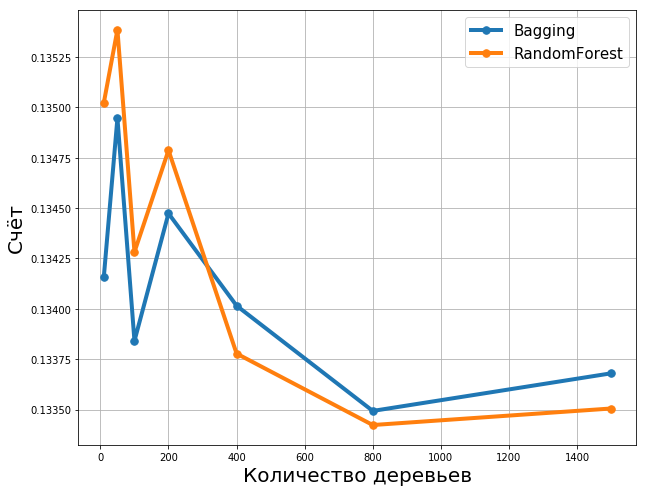

In [141]:
plt.plot(n, scores_bagging, marker='.', label='Bagging', linewidth=4, markersize=15)
plt.plot(n, scores_forest, marker='.', label='RandomForest', linewidth=4, markersize=15)
plt.grid(True)
# plt.title("Сравнение бэггинга и случайного леса")
plt.xlabel('Количество деревьев', fontsize=20)
plt.ylabel('Счёт', fontsize=20)
plt.legend(loc='upper right', fontsize=15)
plt.savefig("figures/bag_vs_forest.png")

### Случайны лес с настройкой параметров

In [142]:
params_grid_rf = {
    "n_estimators": [800, 1500], 
    "max_features": [0.2, 0.3, 0.5, 0.7, 1],
    "max_depth": [10, 15, 20],
    "min_samples_leaf": [1],
    "random_state": [19]
}

rf = RandomForestRegressor(n_jobs=-1, verbose=0)
est_rf = GridSearchCV(rf, param_grid=params_grid_rf)

In [143]:
%%time
est_rf.fit(X_train, y_train).best_params_

CPU times: user 1min 54s, sys: 30.7 s, total: 2min 24s
Wall time: 3min 26s


{'max_depth': 15,
 'max_features': 0.5,
 'min_samples_leaf': 1,
 'n_estimators': 1500,
 'random_state': 19}

In [145]:
params_rf = {
    'n_jobs': -1, 
    'max_depth': 15, 
    'max_features': 0.5, 
    'min_samples_leaf': 1, 
    'n_estimators': 1500
}
rf = RandomForestRegressor(**params_rf, random_state=19).fit(X_train, y_train)
predict_rf_test = rf.predict(X_test)
predict_rf_train = rf.predict(X_train)

In [146]:
%%time
print("MSE:", mean_squared_error(predict_rf_test, y_test))
cross_validation_score(estimator=rf)

MSE: 0.12791414599383058
Cross-validation score:  0.8107556312589587
CPU times: user 1min 25s, sys: 48.1 s, total: 2min 13s
Wall time: 5min 49s


In [150]:
test_id = pd.read_csv('data/test.csv')
submission = pd.DataFrame({'Id' : test_id['Id'], 'SalePrice' : np.exp(predict_rf_test) + 1})
submission.to_csv("./submission-rf-16_06_2020.csv", index=False)

#### Далее посмотрим на самые ценные признаки

In [151]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
num_to_plot = 15
feature_indices = [ind + 1 for ind in indices[:num_to_plot]]

d = dict()
importances_cols = list()

features = X_train.columns
for i in range(len(features)):
    d[features[i]] = importances[i]
    if d[features[i]] >= 0.005:
        importances_cols.append([features[i], importances[i]])

importances_cols.sort(key=lambda x: x[1], reverse=True)
importances_cols

[['TotalArea', 0.45622045087974594],
 ['ExterQual', 0.14237470905405628],
 ['YearRemodAdd', 0.0697031121737935],
 ['GarageType', 0.056936562882594396],
 ['LotArea', 0.027096986771005922],
 ['BsmtFinSF1', 0.023343182054222558],
 ['Fireplaces', 0.022556048256402134],
 ['CentralAir', 0.01612579582606895],
 ['OverallCond', 0.01492600481989503],
 ['Neighborhood', 0.013532769457827103],
 ['TotalPorchSF', 0.011979786423987967],
 ['BsmtUnfSF', 0.011744397170644764],
 ['HeatingQC', 0.011154432147127458],
 ['MasVnrArea', 0.010398922450772424],
 ['MSZoning', 0.009514735816205879],
 ['GarageCond', 0.008802721244159104],
 ['HouseStyle', 0.00869545998589395],
 ['GarageFinish', 0.0077615979158553805],
 ['LotFrontage', 0.007620585507302383],
 ['MoSold', 0.00614808225246015],
 ['BedroomAbvGr', 0.006064156719813957]]

Text(0.5, 1.0, 'Самые ценные признаки')

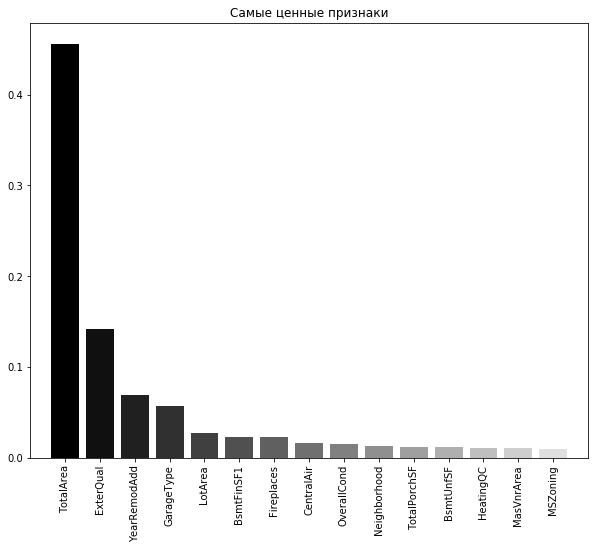

In [152]:
cols = list()
for x in importances_cols:
    cols.append(x[0])

    
fig, ax = plt.subplots()
features = X_train.columns
ax.bar(range(num_to_plot),
       importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) for i in range(num_to_plot)]),
       align="center")


ticks = plt.xticks(range(num_to_plot), feature_indices)
ax.set_xticklabels(cols, rotation = 90)
plt.xlim([-1, num_to_plot])
plt.title("Самые ценные признаки")

In [115]:
79283.70398550337 - 73354.20621779385

5929.497767709516

target_train 	mean: 180577.71389270975 	std: 79283.70398550337
predict_train 	mean: 179076.38941761057 	std: 73354.20621779385


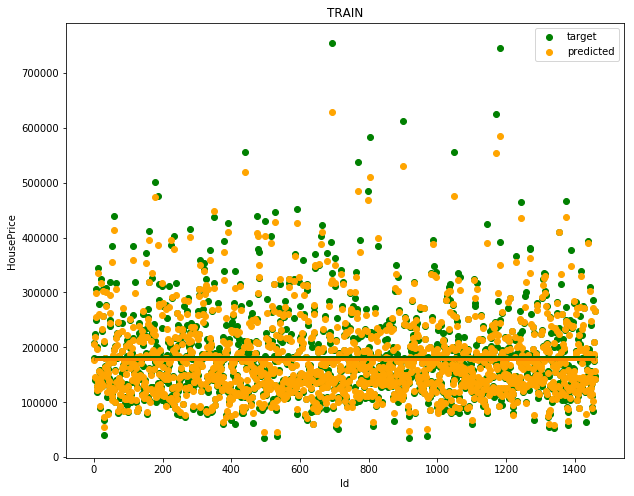

In [182]:
plt.scatter(train['Id'], np.exp(y_train) - 1, c='green', label='target')
plt.scatter(train['Id'], np.exp(predict_rf_train) - 1, c='orange', label='predicted')
plt.hlines(np.mean(np.exp(y_train) - 1), min(train['Id']), max(train['Id']), color='darkgreen', linewidth = 5)
plt.hlines(np.mean(np.exp(predict_rf_train) - 1), min(train['Id']), max(train['Id']), color='darkorange', linewidth = 3)
plt.title('TRAIN')
plt.xlabel('Id')
plt.ylabel('HousePrice')
plt.legend(loc='upper right')
plt.savefig("figures/rf_train.png")
print("target_train \tmean:", np.mean(np.exp(y_train) - 1), "\tstd:", np.std(np.exp(y_train) - 1))
print("predict_train \tmean:", np.mean(np.exp(predict_rf_train) - 1), "\tstd:", np.std(np.exp(predict_rf_train) - 1))

target_test 	mean: 179183.91824266256 	std: 16512.641250201952
predict_test 	mean: 175013.75916052068 	std: 70278.07313070579


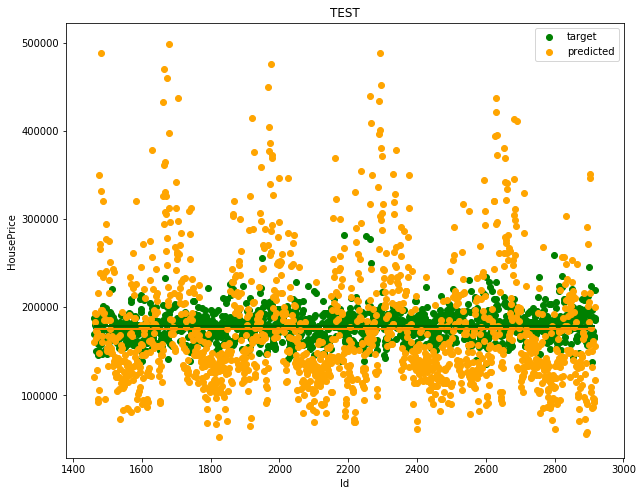

In [183]:
plt.scatter(test['Id'], np.exp(y_test) - 1, c='green', label='target')
plt.scatter(test['Id'], np.exp(predict_rf_test) - 1, c='orange', label='predicted')
plt.hlines(np.mean(np.exp(y_test) - 1), min(test['Id']), max(test['Id']), color='darkgreen', linewidth = 2)
plt.hlines(np.mean(np.exp(predict_rf_test) - 1), min(test['Id']), max(test['Id']), color='darkorange', linewidth = 2)
plt.title('TEST')
plt.xlabel('Id')
plt.ylabel('HousePrice')
plt.legend(loc='upper right')
plt.savefig("figures/rf_test.png")
print("target_test \tmean:", np.mean(np.exp(y_test) - 1), "\tstd:", np.std(np.exp(y_test) - 1))
print("predict_test \tmean:", np.mean(np.exp(predict_rf_test) - 1), "\tstd:", np.std(np.exp(predict_rf_test) - 1))

In [117]:
16512.641250201952 - 70278.07313070579

-53765.431880503835

In [125]:
params_grid_bag = {
    "n_estimators": [100, 300, 500, 800, 1000],
    "max_features": [0.2, 0.3, 0.4],
    "max_samples": [0.5, 0.1],
    "bootstrap": [True, False],
    "bootstrap_features": [True, False]
}
bag = BaggingRegressor(n_jobs=-1, verbose=0)
est_bag = GridSearchCV(bag, param_grid=params_grid_bag)

In [126]:
%%time
est_bag.fit(X_train, y_train).best_params_

CPU times: user 2min 34s, sys: 39.8 s, total: 3min 14s
Wall time: 6min 40s


{'bootstrap': False,
 'bootstrap_features': False,
 'max_features': 0.4,
 'max_samples': 0.5,
 'n_estimators': 800}

In [138]:
params_bag = {
    "n_jobs": -1,
    "n_estimators": 800,
    "max_features": 0.4,
    "max_samples": 0.5,
    "bootstrap": False,
    "bootstrap_features": False
}
bag = BaggingRegressor(**params_bag, random_state=19).fit(X_train, y_train)
predict_bag_test = bag.predict(X_test)
predict_bag_train = bag.predict(X_train)

In [139]:
print("MSE:", mean_squared_error(predict_bag_test, np.log(y_test + 1)))

MSE: 0.12358896309323113


In [166]:
test_id = pd.read_csv('data/test.csv')
submission = pd.DataFrame({'Id' : test_id['Id'], 'SalePrice' : np.exp(predict_bag_test) - 1})
submission.to_csv("./submission-bag-15_06_2020.csv", index=False)

### Эксперимент с совмещением выборок

In [173]:
X = pd.concat(objs=[X_train, X_test], axis=0)
y = pd.concat(objs=[y_train, y_test], axis=0)

In [174]:
params_grid_rf_t = {
    "n_estimators": [800, 1000, 1200], 
    "max_features": [0.3, 0.6, 1],
    "max_depth": [15, 20, 25],
    "min_samples_leaf": [1],
    "random_state": [19]
}

rf_t = RandomForestRegressor(n_jobs=-1, verbose=0)
est_rf_t = GridSearchCV(rf_t, param_grid=params_grid_rf_t)

In [175]:
%%time
est_rf_t.fit(X, y).best_params_

CPU times: user 2min 4s, sys: 52.6 s, total: 2min 57s
Wall time: 4min 53s


{'max_depth': 20,
 'max_features': 0.3,
 'min_samples_leaf': 1,
 'n_estimators': 800,
 'random_state': 19}

In [177]:
params_rf_t = {
    "n_jobs": -1,
    "max_depth": 20,
    "n_estimators": 800,
    "max_features": 0.3,
    "min_samples_leaf": 1
}
rf_t = RandomForestRegressor(**params_rf_t, random_state=19).fit(X, y)
predict_rf_t_test = rf_t.predict(X_test)
predict_rf_t_train = rf_t.predict(X_train)

In [184]:
print("MSE:", mean_squared_error(np.log(predict_rf_t_test + 1), np.log(y_test + 1)))

MSE: 0.0003609652110154253


In [183]:
y_test

array([169559.83520993, 187254.83813753, 184391.41677022, ...,
       214688.37209397, 178915.3437165 , 187061.81324935])

In [ ]:
# test_id = pd.read_csv('data/test.csv')
# submission = pd.DataFrame({'Id' : test_id['Id'], 'SalePrice' : np.exp(predict_test) - 1})
# submission.to_csv("./submission-rf-09_06_2020.csv", index=False)

In [ ]:
# На данный момент это лучший вариант:

In [ ]:
params = {
    'n_jobs': -1, 
    'max_depth': 20, 
    'max_features': 0.2, 
    'min_samples_leaf': 1, 
    'n_estimators': 800
}
rf = RandomForestRegressor(**params).fit(X_train, y_train)
predict_test = rf.predict(X_test)
# predict_test = np.expm1(predict_test)
predict_train = rf.predict(X_train)
# predict_train = np.expm1(predict_train)

In [ ]:
# # Визуализация одного дерева

# single_tree = rf.estimators_[5]

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(single_tree, out_file='tree.dot', 
#                 feature_names = train.columns[1:-1],
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# # Display in jupyter notebook
# from IPython.display import Image
# Image(filename = 'tree.png')

In [ ]:
%%time
xg = xgboost.XGBRegressor()
param_grid = dict(learning_rate = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3], max_depth = [3,4,5,6,8,10,12,15],
                 min_child_weight = [1,3,5,7], gamma = [0.0,0.1,0.2,0.3,0.4], colsample_bytree = [0.3,0.4,0.5,0.6])
grid_xg = RandomizedSearchCV(xg, param_grid, cv=10, scoring = 'r2')
grid_xg.fit(X_train,y_train)

In [ ]:
grid_xg.best_params_

In [ ]:
params_xgb = {
    'min_child_weight': 7,
    'max_depth': 8,
    'learning_rate': 0.1,
    'gamma': 0.0,
    'colsample_bytree': 0.6,
    'n_estimators': 1000
}
xg = xgboost.XGBRegressor(**params_xgb).fit(X_train,y_train)
predict_xg = xg.predict(X_test)
predict_xg

In [ ]:
print(mean_squared_error(predict_xg, y_test + 1))